In [1]:
import numpy as np 
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from cdo import *
import os
import pymannkendall as mk
CDO = Cdo()

In [2]:
data = xr.open_dataset('../INDICES/ECA_r10MM_HEAVY_PRECIPITATION/1998_eca_r10mm/1998_00_eca_r10mm.nc')
data

<xarray.Dataset>
Dimensions:                                         (time: 1, lon: 119,
                                                     bnds: 2, lat: 117)
Coordinates:
  * time                                            (time) datetime64[ns] 199...
  * lon                                             (lon) float64 68.12 ... 9...
  * lat                                             (lat) float64 6.625 ... 3...
Dimensions without coordinates: bnds
Data variables:
    lon_bnds                                        (lon, bnds) float64 ...
    lat_bnds                                        (lat, bnds) float64 ...
    heavy_precipitation_days_index_per_time_period  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.2.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Oct 18 14:42:14 2023: cdo -O -s -eca_r10mm /var/folders...
    CDO:          Climate Data Operators version 2.2.1 (https://mpimet.mpg.de...

In [3]:
def SenSlope(max_1_day_prec):
    row=0
    col=0
    count=[]
    data_all_year_max_1_day_prec = []
    plot_data=[]
    intercept_plot=[]
    mk_test_all_values=[]
    all_values_for_max_1_day_prec_on_each_grid = []
    for grids in max_1_day_prec[0]:
        col=0
        for grid_point in grids:
            data_all_year_max_1_day_prec = []
            # if(str(grid_point)!='nan'):
            data_all_year_max_1_day_prec.append(grid_point)
            for index in range(1,len(max_1_day_prec)):
                # if(str(max_1_day_prec[index][row][col])!='nan'):
                data_all_year_max_1_day_prec.append(max_1_day_prec[index][row][col])
            all_values_for_max_1_day_prec_on_each_grid.append(data_all_year_max_1_day_prec)
            try:
                slope,intercept = mk.sens_slope(data_all_year_max_1_day_prec) 
                plot_data.append(slope)
                intercept_plot.append(intercept)
                count.append(slope)
            except:
                plot_data.append(np.nan)
                intercept_plot.append(np.nan)
                mk_test_all_values.append(np.nan)
            col = col + 1
        row = row + 1
    plot_data = np.array(plot_data).reshape(117,119)
    intercept_plot = np.array(intercept_plot).reshape(117,119)
    plot_data = xr.Dataset({
    "Heavy_Precipitation_Man_Kendall_Results":(["lat","lon"],plot_data),
    # "Yue_Wang_test_values":(["x","y"],pd.DataFrame(mk_test_all_values))
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
    # "time": pd.date_range("2014-09-06", periods=3),
}
)
    
    intercept_plot = xr.Dataset({
    "Heavy_Precipitation_Man_Kendall_Results":(["lat","lon"],intercept_plot),
    # "Yue_Wang_test_values":(["x","y"],pd.DataFrame(mk_test_all_values))
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
    # "time": pd.date_range("2014-09-06", periods=3),
}
)
    return plot_data,intercept_plot,count

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature
def PlotGraph(plot_data,test="Men Kendall",hour="0th",cmap=""):
    # Create a map using PlateCarree projection
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    # Add map features
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False  
    gl.ylabels_right = False 
    gl.xlines = True 
    gl.ylines = True 
    lats = data['lat'].values
    lons = data['lon'].values[:-2]
    # ax.contourf(ds_21['Heavy_Precipitation_Yue_Wang_Results'])
    # ds_21['Heavy_Precipitation_Yue_Wang_Results'].plot.contourf(cmap="coolwarm")
    if cmap != "":
        plot_data['Heavy_Precipitation_Man_Kendall_Results'].plot(cmap=cmap)
    else:
        plot_data['Heavy_Precipitation_Man_Kendall_Results'].plot(cmap="seismic_r")
    # ax.plot(lons,lats,color="#00000000")
    # Plot data

    # ax.scatter(lons, lats,transform=ccrs.PlateCarree())

    # Customize and display the map
    plt.title(f'Heavy Precipitation\n{test} results {hour} hour 1998-2019')
    plt.show()
    # turbo , coolwarm , coolwarm_r , bwr , bwr_r , 

In [5]:
def ManKendallTest(max_1_day_prec):
    row=0
    col=0
    year=1
    data_all_year_max_1_day_prec = []
    plot_data=[]
    mk_test_all_values=[]
    all_values_for_max_1_day_prec_on_each_grid = []
    for grids in max_1_day_prec[0]:
        col=0
        for grid_point in grids:
            data_all_year_max_1_day_prec = []
            # if(str(grid_point)!='nan'):
            data_all_year_max_1_day_prec.append(grid_point)
            for index in range(1,len(max_1_day_prec)):
                # if(str(max_1_day_prec[index][row][col])!='nan'):
                data_all_year_max_1_day_prec.append(max_1_day_prec[index][row][col])
            all_values_for_max_1_day_prec_on_each_grid.append(data_all_year_max_1_day_prec)
            try:
                op = mk.original_test(data_all_year_max_1_day_prec) 
                mk_test_all_values.append(op)
                if(op.trend=='increasing'):
                    plot_data.append(1)
                elif(op.trend=='no trend'):
                    plot_data.append(0)
                else:
                    plot_data.append(-1)
            except:
                plot_data.append(np.nan)
                mk_test_all_values.append(np.nan)
            col = col + 1
        row = row + 1
    plot_data = np.array(plot_data).reshape(117,119)
    plot_data = xr.Dataset({
    "Heavy_Precipitation_Man_Kendall_Results":(["lat","lon"],plot_data),
    # "Yue_Wang_test_values":(["x","y"],pd.DataFrame(mk_test_all_values))
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
    # "time": pd.date_range("2014-09-06", periods=3),
}
)
    return plot_data

In [6]:
def LoadData(hour):
    heavy_prec = []
    for year in range(1998,2020):
        data = xr.open_dataset(f'../INDICES/ECA_r10MM_HEAVY_PRECIPITATION/{year}_eca_r10mm/{year}_{hour}_eca_r10mm.nc')
        heavy_prec.append(data['heavy_precipitation_days_index_per_time_period'].values[0])
    return heavy_prec

In [9]:
increasing_count = []
decreasing_count = []

In [10]:
def CountGrids(count):
    p=0
    n=0 
    nn=0
    o=0
    for i in count:
        if i>0:
            p=p+1
        elif i<0:
            n=n+1
        elif i==0:
            o=o+1
        elif str(i)=='nan':
            nn=nn+1
    increasing_count.append(p)
    decreasing_count.append(-n)
    print(f'p={p},n={-n},nn={nn},o={o}\nTotal = {p+n+nn+o}')

In [13]:
def GridPlot(increasing_count,decreasing_count,year='1998-2019'):
    x = [0,3,6,9,12,15,18,21]
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.xticks(x)
    ax.bar(x, increasing_count, width=0.7, color='b')
    ax.bar(x, decreasing_count, width=0.7, color='r')
    plt.xlabel("Hours")
    plt.ylabel("Number of Grids")
    plt.title(f"Total Increasing and Decreasing Grids for Heavy Precipitation {year}")
    plt.legend({'Increasing':'blue','Decreasing':'red'})

## 0th Hour

In [34]:
heavy_prec = LoadData("00")
heavy_prec

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [35]:
plot_data = ManKendallTest(heavy_prec)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


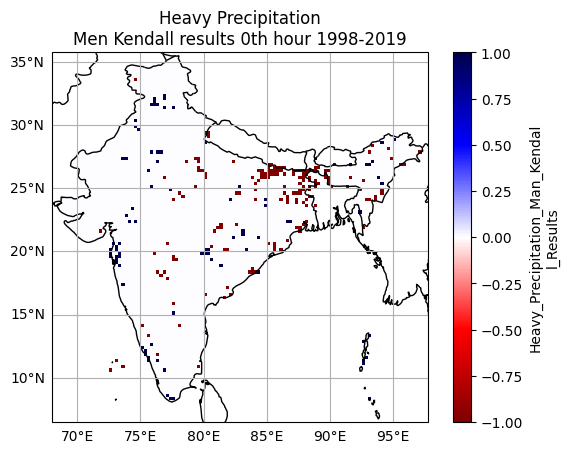

In [38]:
PlotGraph(plot_data)

In [39]:
plot_data_2,intercept_plot = SenSlope(heavy_prec)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


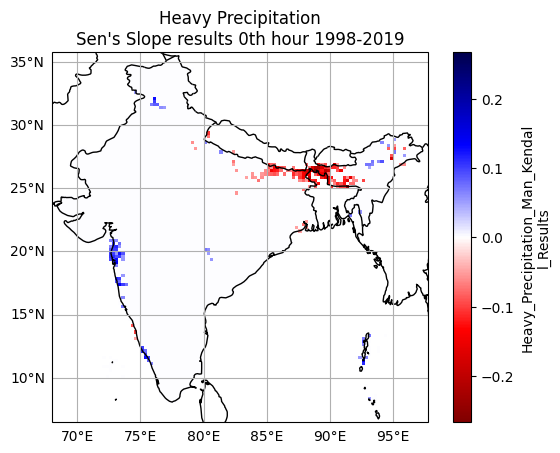

In [40]:
PlotGraph(plot_data_2,test="Sen\'s Slope")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


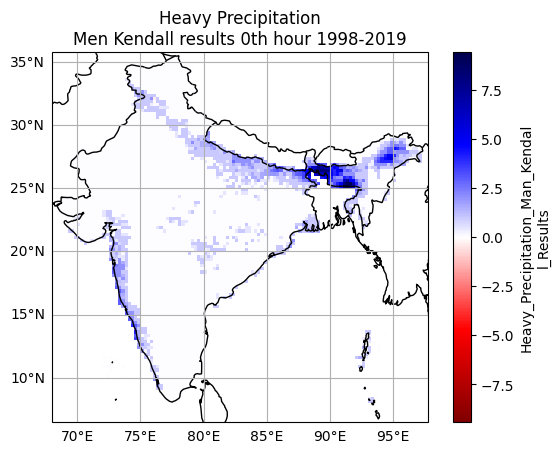

In [41]:
PlotGraph(intercept_plot)

In [32]:
avg=0
for i in heavy_prec:
    avg = avg + i
avg

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [35]:
avg = xr.Dataset({
    "Max_1_Day_Precipitation_Man_Kendall_Results":(["lat","lon"],avg),
    # "Yue_Wang_test_values":(["x","y"],pd.DataFrame(mk_test_all_values))
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
    # "time": pd.date_range("2014-09-06", periods=3),
}
)

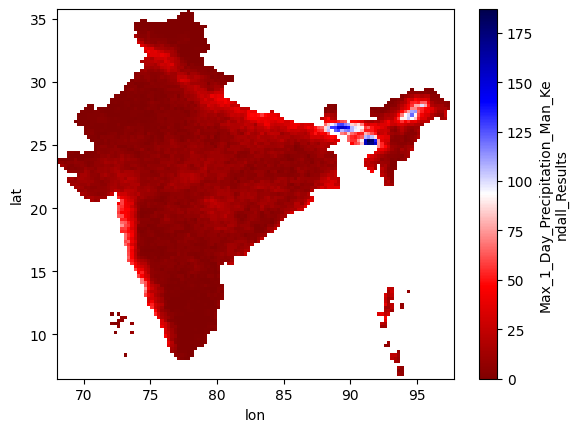

In [59]:
avg['Max_1_Day_Precipitation_Man_Kendall_Results'].plot(cmap="seismic_r")

## 3rd Hour

In [42]:
heavy_prec = LoadData("03")
heavy_prec

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [43]:
plot_data = ManKendallTest(heavy_prec)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


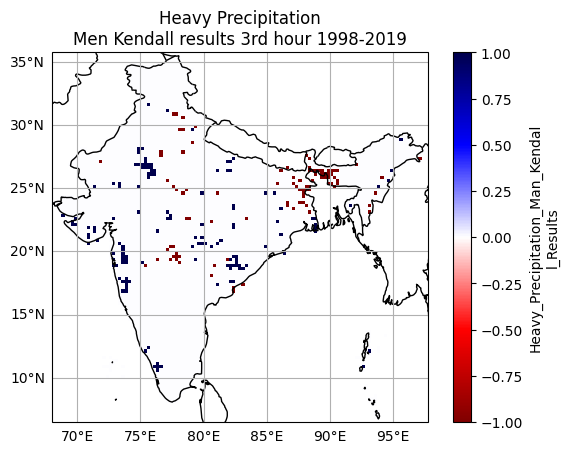

In [44]:
PlotGraph(plot_data,hour="3rd")

In [45]:
plot_data,intercept_plot = SenSlope(heavy_prec)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


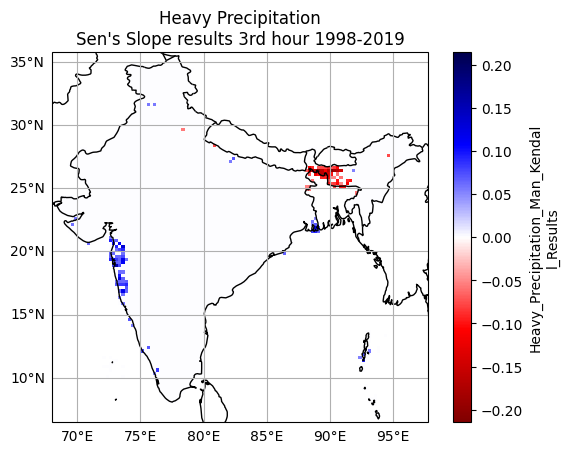

In [46]:
PlotGraph(plot_data,test="Sen\'s Slope",hour="3rd")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


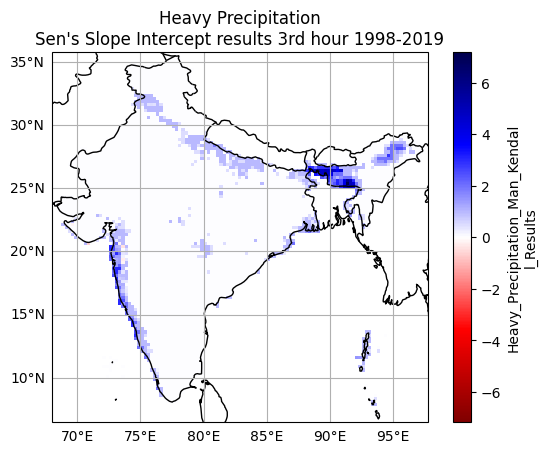

In [47]:
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="3rd")

## 6th Hour

In [48]:
heavy_prec = LoadData("06")
heavy_prec

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [49]:
plot_data = ManKendallTest(heavy_prec)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


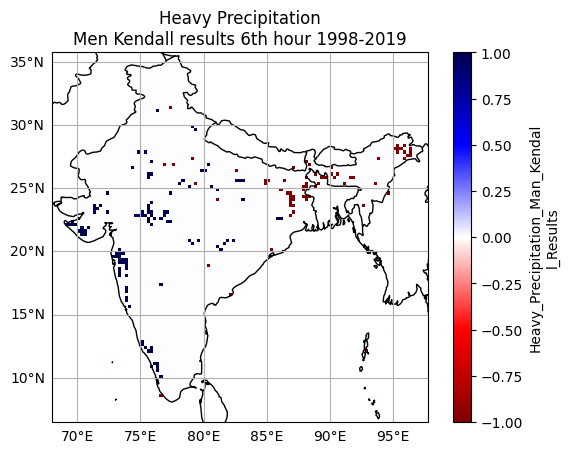

In [50]:
PlotGraph(plot_data,hour="6th")

In [51]:
plot_data,intercept_plot = SenSlope(heavy_prec)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


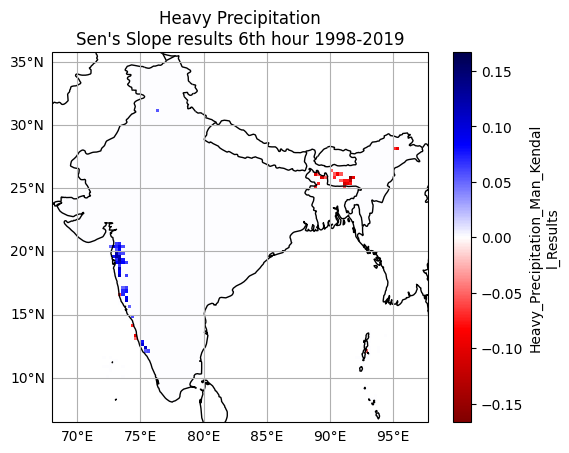

In [52]:
PlotGraph(plot_data,test="Sen\'s Slope",hour="6th")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


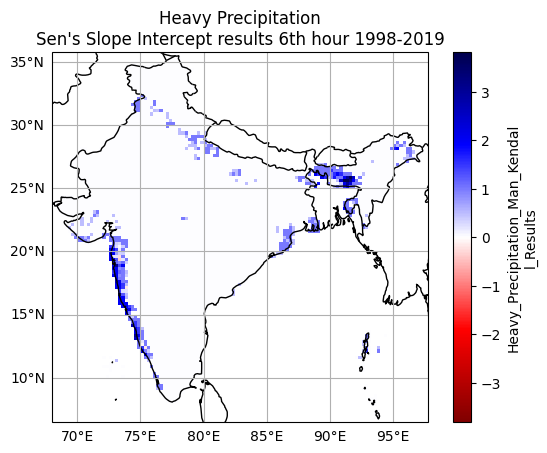

In [53]:
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="6th")

## 9th Hour

In [11]:
heavy_prec = LoadData("09")
heavy_prec

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [17]:
plot_data = ManKendallTest(heavy_prec)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


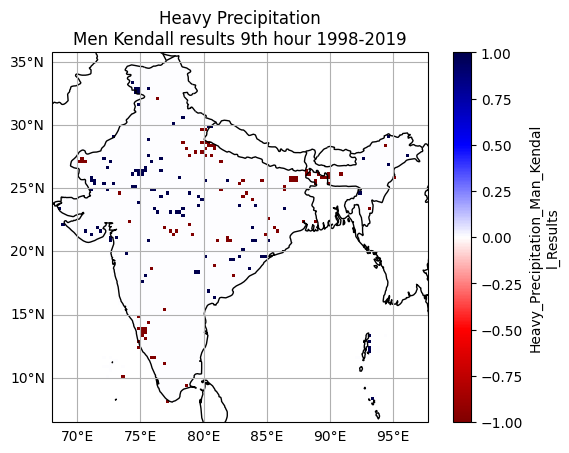

In [18]:
PlotGraph(plot_data,hour="9th")

In [14]:
plot_data,intercept_plot = SenSlope(heavy_prec)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


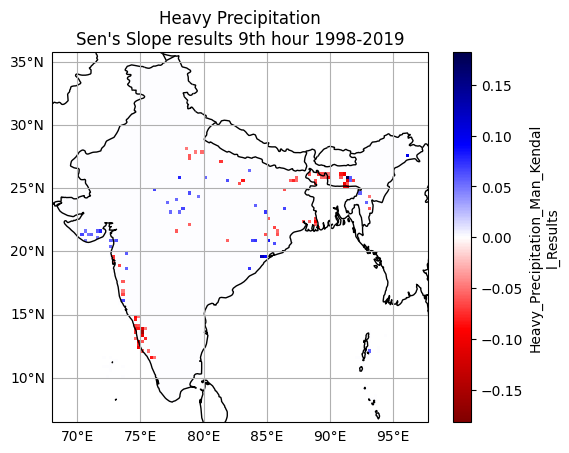

In [15]:
PlotGraph(plot_data,test="Sen\'s Slope",hour="9th")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


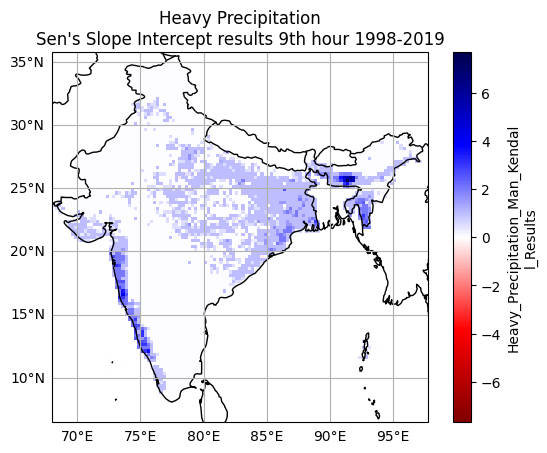

In [16]:
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="9th")


## 12th Hour

In [19]:
heavy_prec = LoadData("12")
heavy_prec

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [20]:
plot_data = ManKendallTest(heavy_prec)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


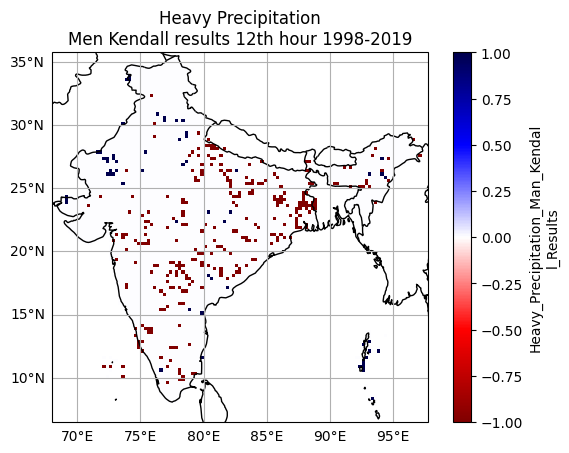

In [21]:
PlotGraph(plot_data,hour="12th")

In [22]:
plot_data,intercept_plot = SenSlope(heavy_prec)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


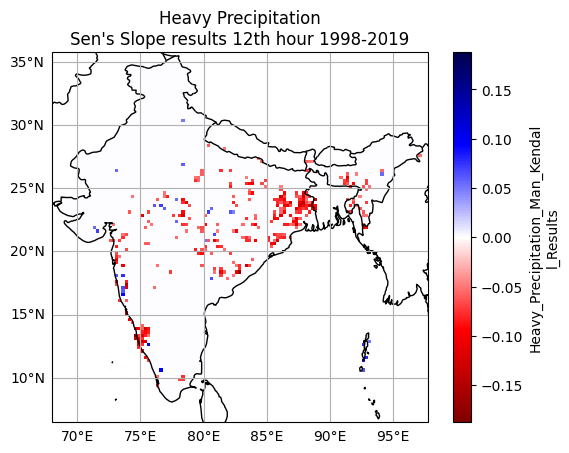

In [23]:
PlotGraph(plot_data,test="Sen\'s Slope",hour="12th")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


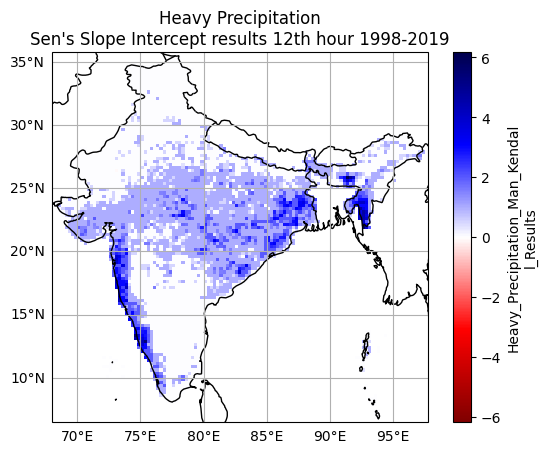

In [24]:
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="12th")

## 15th hour

In [25]:
heavy_prec = LoadData("15")
heavy_prec

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [26]:
plot_data = ManKendallTest(heavy_prec)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


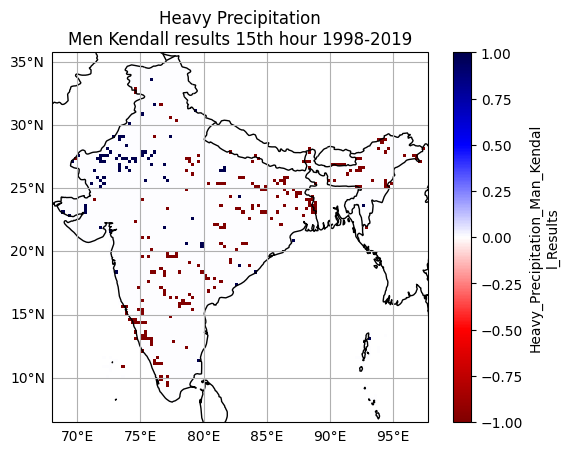

In [28]:
PlotGraph(plot_data,hour="15th")

In [29]:
plot_data,intercept_plot = SenSlope(heavy_prec)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


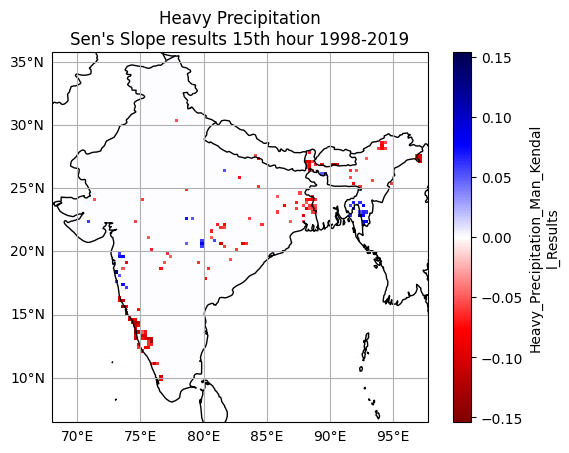

In [30]:
PlotGraph(plot_data,test="Sen\'s Slope",hour="15th")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


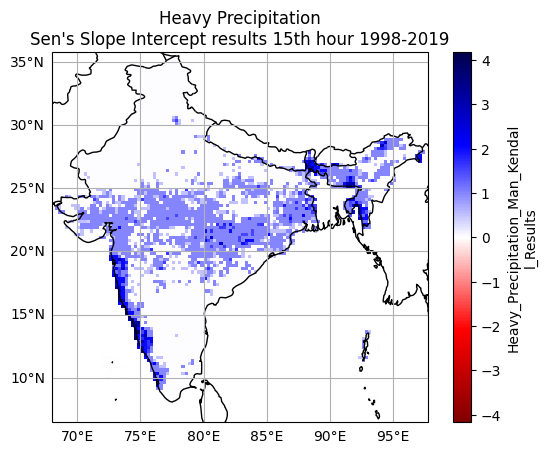

In [31]:
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="15th")

## 18th Hour

In [32]:
heavy_prec = LoadData("18")
heavy_prec

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [33]:
plot_data = ManKendallTest(heavy_prec)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


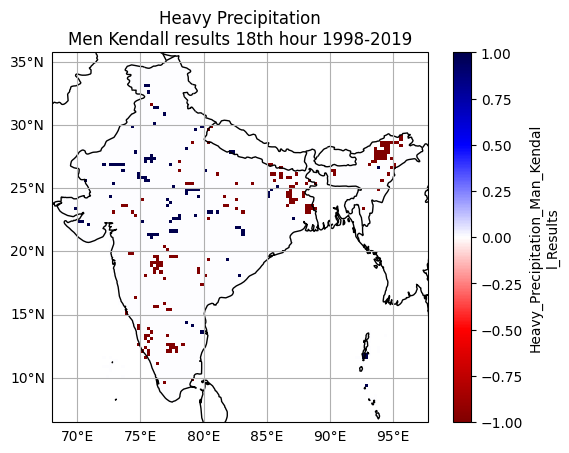

In [34]:
PlotGraph(plot_data,hour="18th")

In [35]:
plot_data,intercept_plot = SenSlope(heavy_prec)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


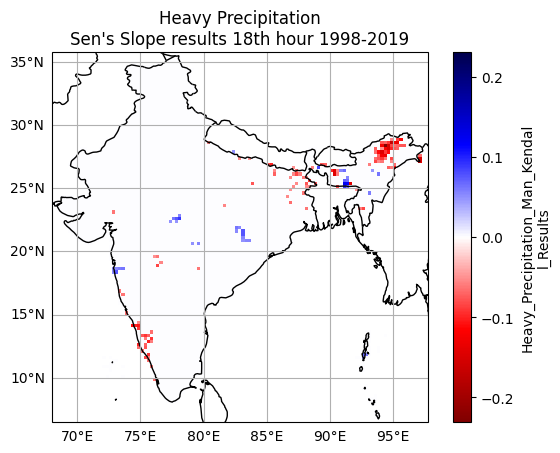

In [36]:
PlotGraph(plot_data,test="Sen\'s Slope",hour="18th")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


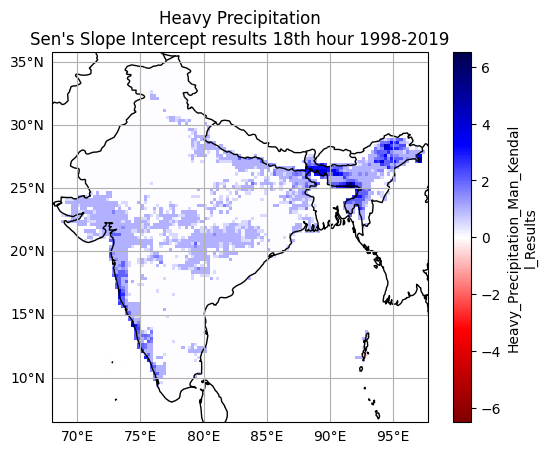

In [37]:
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="18th")

## 21st Hour

In [38]:
heavy_prec = LoadData("21")
heavy_prec

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [39]:
plot_data = ManKendallTest(heavy_prec)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


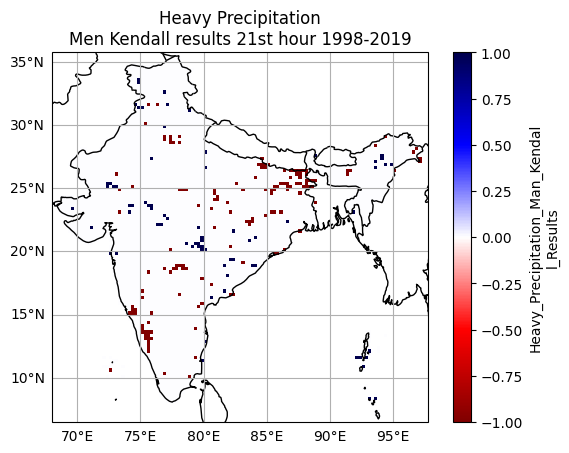

In [40]:
PlotGraph(plot_data,hour="21st")

In [41]:
plot_data,intercept_plot = SenSlope(heavy_prec)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


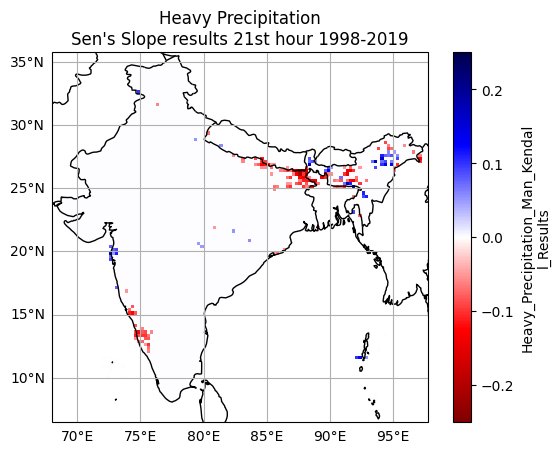

In [42]:
PlotGraph(plot_data,test="Sen\'s Slope",hour="21st")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


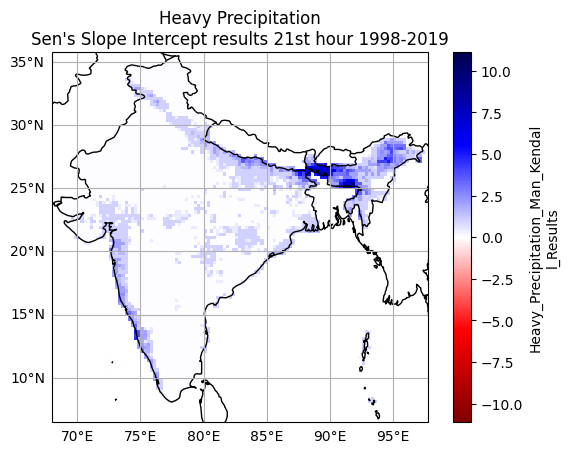

In [43]:
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="21st")

# With GPM

## 0th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

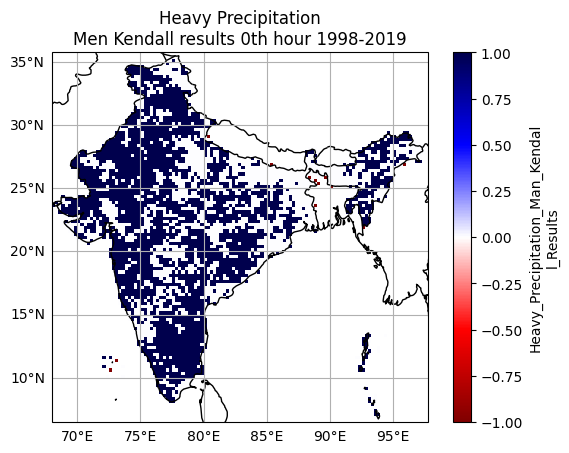

In [42]:
heavy_prec = LoadData("00")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data)

In [37]:
for i in heavy_prec:
    for j in i:
        print(j)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan  1.  1. nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

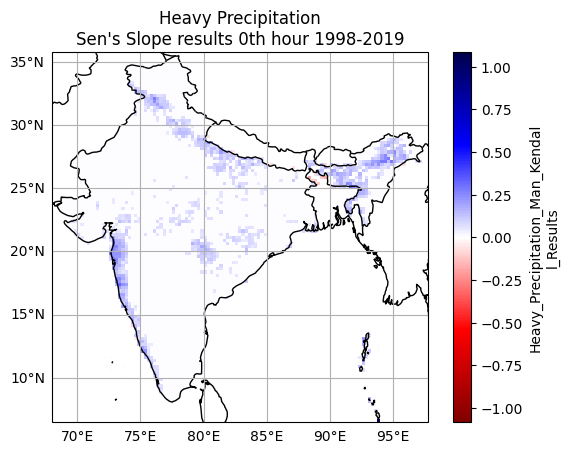

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


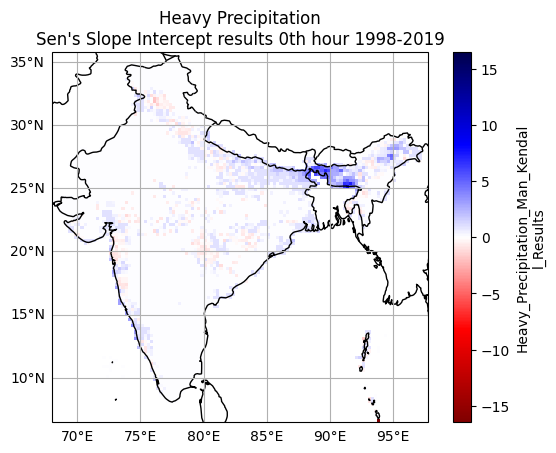

In [32]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept")

## 3rd Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

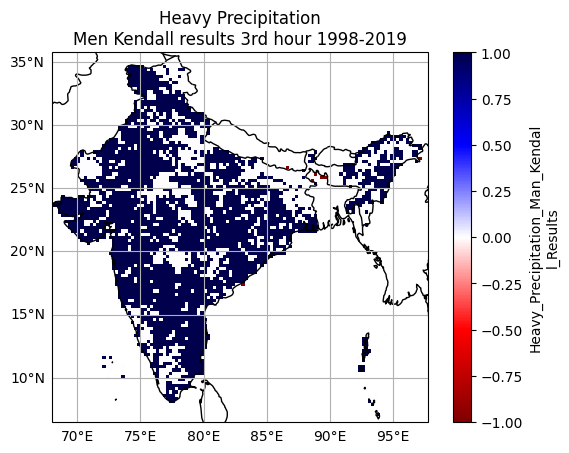

In [13]:
heavy_prec = LoadData("03")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="3rd")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

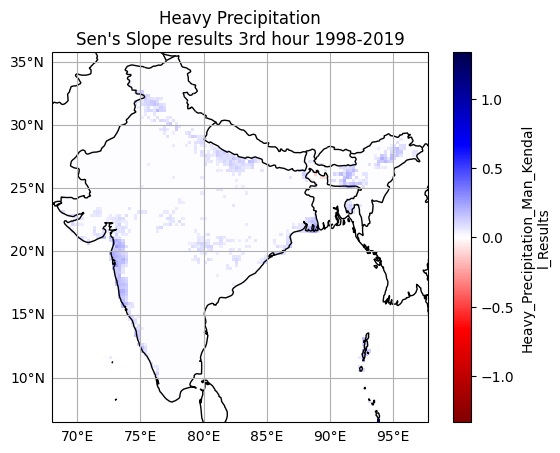

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


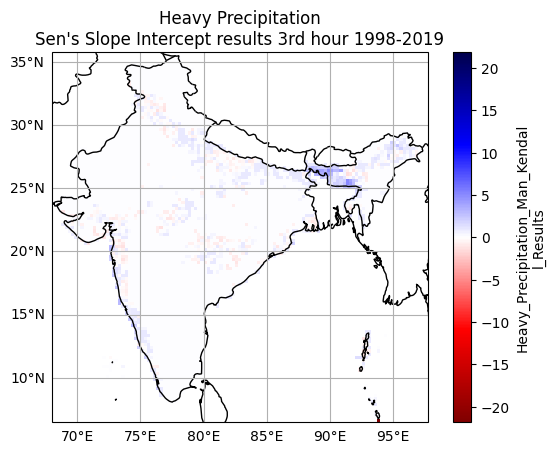

In [14]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="3rd")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="3rd")

## 6th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

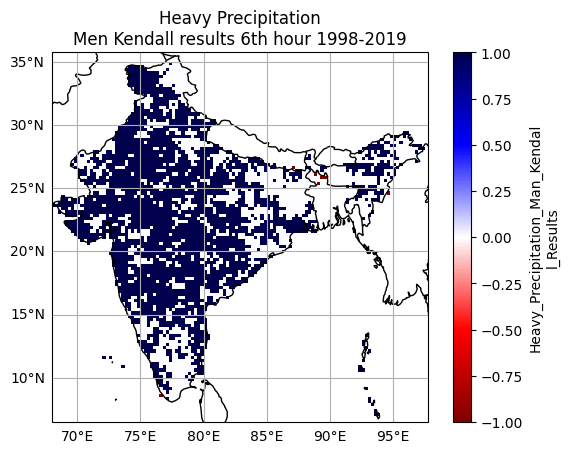

In [15]:
heavy_prec = LoadData("06")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="6th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

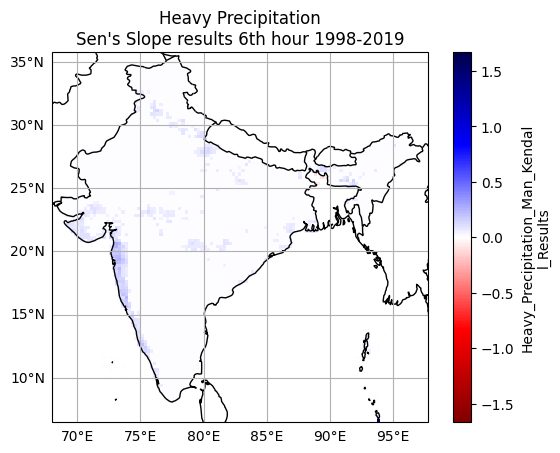

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


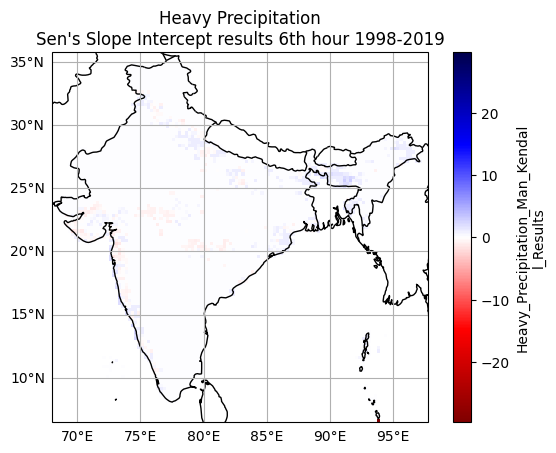

In [16]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="6th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="6th")

## 9th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

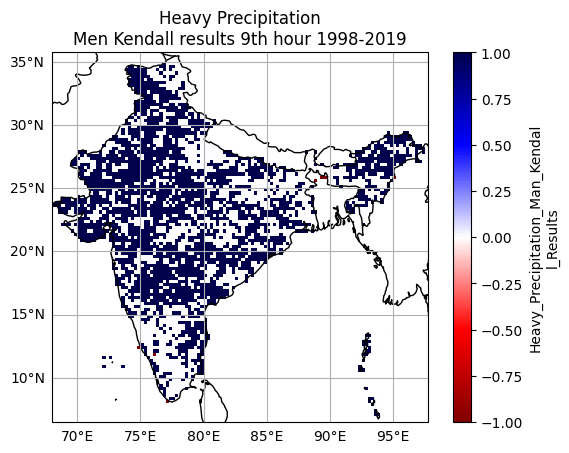

In [17]:
heavy_prec = LoadData("09")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="9th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

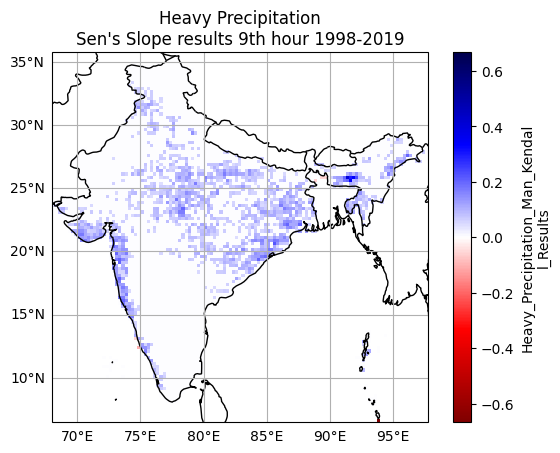

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


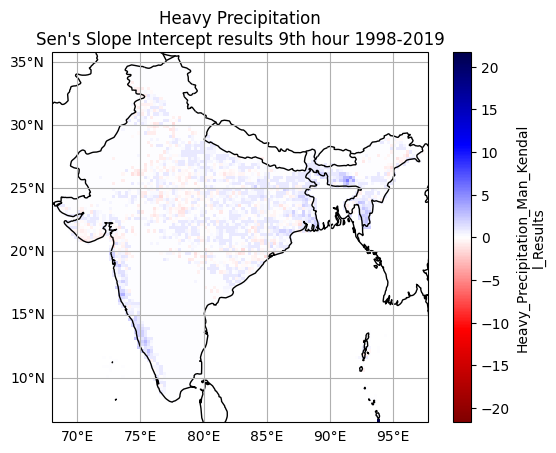

In [18]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="9th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="9th")

## 12th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

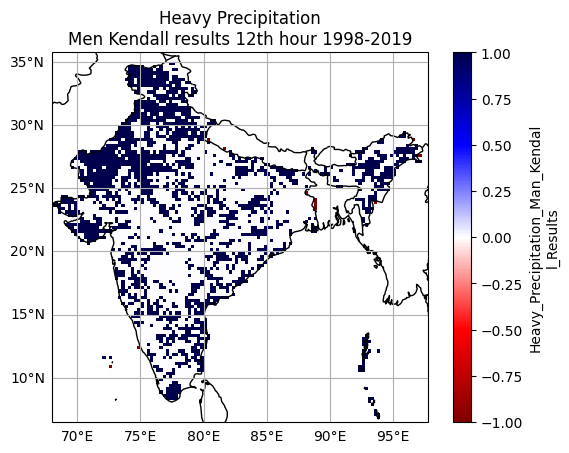

In [19]:
heavy_prec = LoadData("12")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="12th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

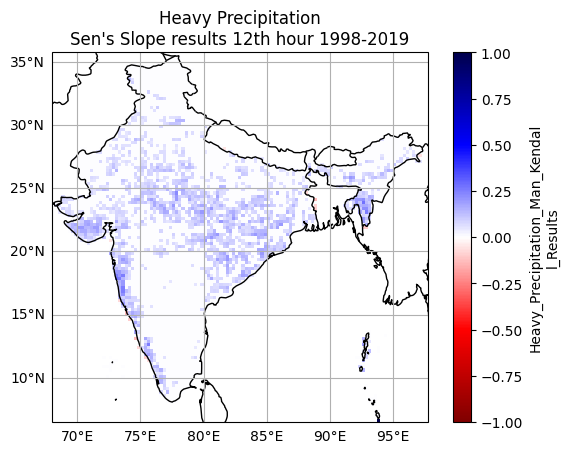

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


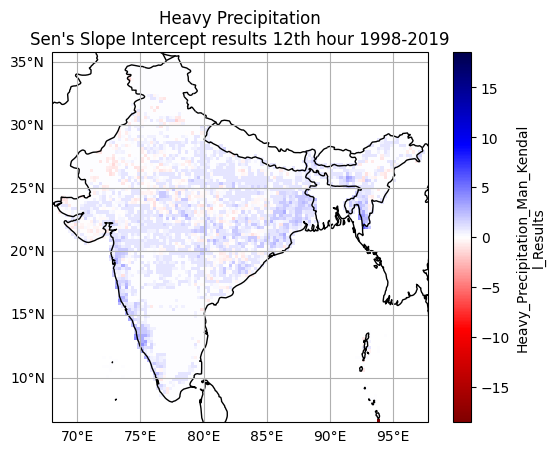

In [20]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="12th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="12th")

## 15th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

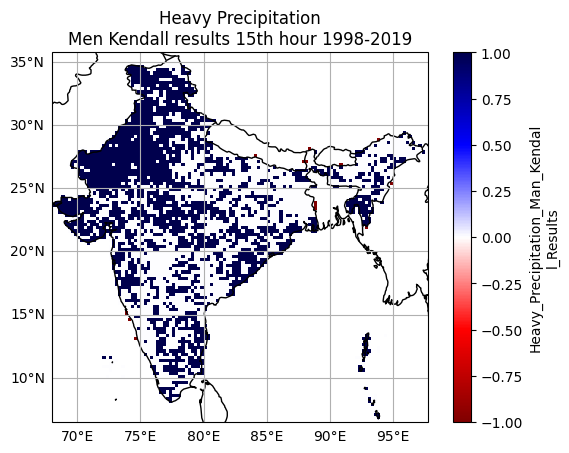

In [21]:
heavy_prec = LoadData("15")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="15th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

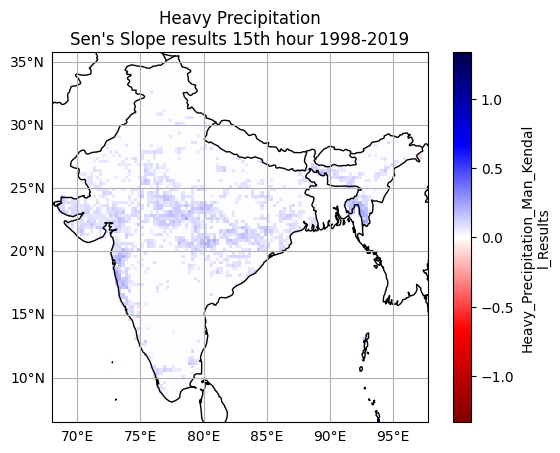

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


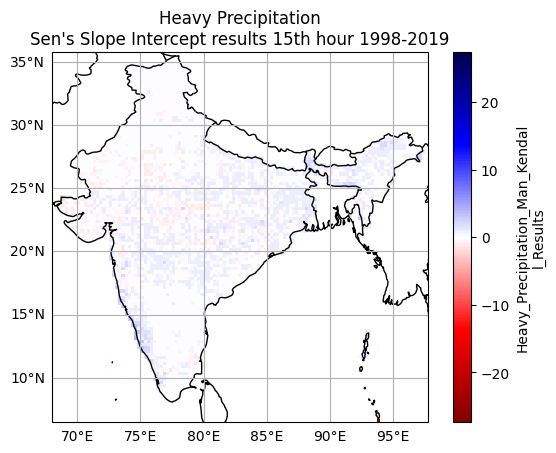

In [22]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="15th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="15th")

## 18th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

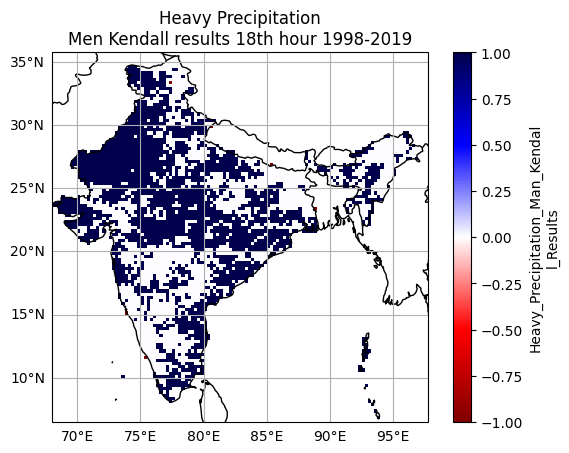

In [23]:
heavy_prec = LoadData("18")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="18th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

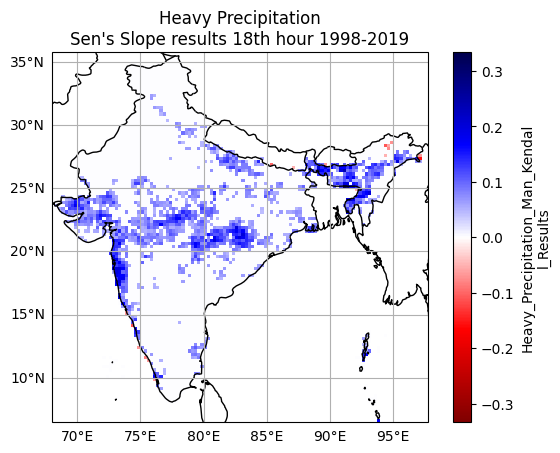

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


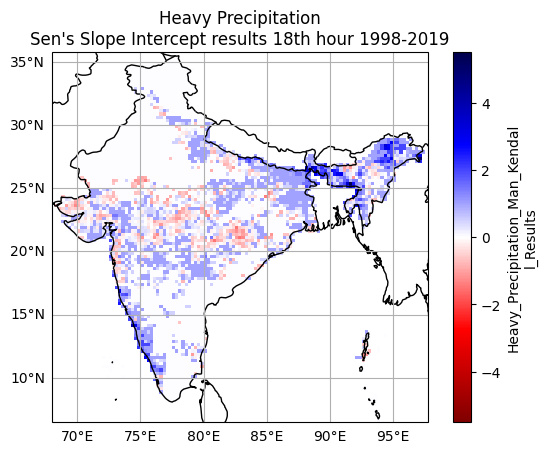

In [24]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="18th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="18th")

## 21st Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

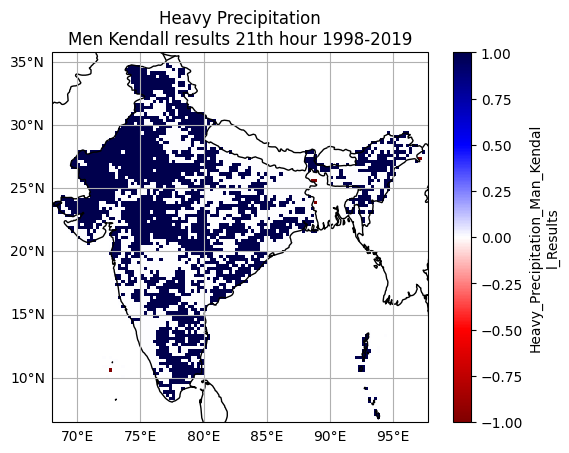

In [25]:
heavy_prec = LoadData("21")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="21th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

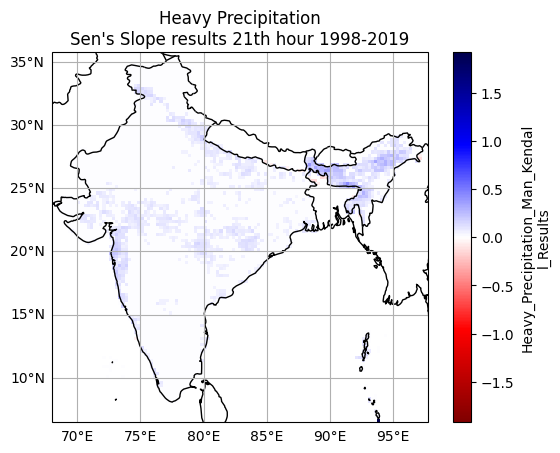

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


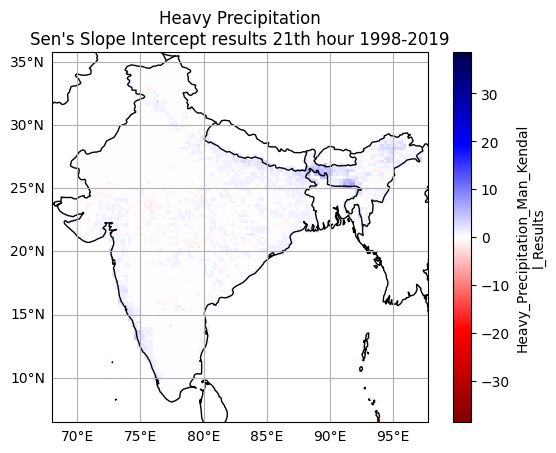

In [26]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="21th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="21th")

## GPM Original Resolution

In [2]:
data = xr.open_dataset('../GPM_Original_Res_Stacks/Stacks/GPM_original_res_stack_2020_00.nc')
data

<xarray.Dataset>
Dimensions:                            (time: 122, lat: 289, lon: 294)
Coordinates:
  * lat                                (lat) float32 6.75 6.85 ... 35.45 35.55
  * lon                                (lon) float32 68.15 68.25 ... 97.35 97.45
Dimensions without coordinates: time
Data variables:
    GPM_3IMERGHHE_06_precipitationCal  (time, lat, lon) float64 ...

In [6]:
def SenSlope(max_1_day_prec):
    row=0
    col=0
    count=[]
    data_all_year_max_1_day_prec = []
    plot_data=[]
    intercept_plot=[]
    mk_test_all_values=[]
    all_values_for_max_1_day_prec_on_each_grid = []
    for grids in max_1_day_prec[0]:
        col=0
        for grid_point in grids:
            data_all_year_max_1_day_prec = []
            # if(str(grid_point)!='nan'):
            data_all_year_max_1_day_prec.append(grid_point)
            for index in range(1,len(max_1_day_prec)):
                # if(str(max_1_day_prec[index][row][col])!='nan'):
                data_all_year_max_1_day_prec.append(max_1_day_prec[index][row][col])
            all_values_for_max_1_day_prec_on_each_grid.append(data_all_year_max_1_day_prec)
            try:
                slope,intercept = mk.sens_slope(data_all_year_max_1_day_prec) 
                plot_data.append(slope)
                intercept_plot.append(intercept)
                count.append(slope)
            except:
                plot_data.append(np.nan)
                intercept_plot.append(np.nan)
                mk_test_all_values.append(np.nan)
            col = col + 1
        row = row + 1
    plot_data = np.array(plot_data).reshape(289,294)
    intercept_plot = np.array(intercept_plot).reshape(289,294)
    plot_data = xr.Dataset({
    "Heavy_Precipitation_Man_Kendall_Results":(["lat","lon"],plot_data),
    # "Yue_Wang_test_values":(["x","y"],pd.DataFrame(mk_test_all_values))
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
    # "time": pd.date_range("2014-09-06", periods=3),
}
)
    
    intercept_plot = xr.Dataset({
    "Heavy_Precipitation_Man_Kendall_Results":(["lat","lon"],intercept_plot),
    # "Yue_Wang_test_values":(["x","y"],pd.DataFrame(mk_test_all_values))
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
    # "time": pd.date_range("2014-09-06", periods=3),
}
)
    return plot_data,intercept_plot,count

In [7]:
def ManKendallTest(max_1_day_prec):
    row=0
    col=0
    year=1
    data_all_year_max_1_day_prec = []
    plot_data=[]
    mk_test_all_values=[]
    all_values_for_max_1_day_prec_on_each_grid = []
    for grids in max_1_day_prec[0]:
        col=0
        for grid_point in grids:
            data_all_year_max_1_day_prec = []
            # if(str(grid_point)!='nan'):
            data_all_year_max_1_day_prec.append(grid_point)
            for index in range(1,len(max_1_day_prec)):
                # if(str(max_1_day_prec[index][row][col])!='nan'):
                data_all_year_max_1_day_prec.append(max_1_day_prec[index][row][col])
            all_values_for_max_1_day_prec_on_each_grid.append(data_all_year_max_1_day_prec)
            try:
                op = mk.original_test(data_all_year_max_1_day_prec,alpha=0.2)
                mk_test_all_values.append(op)
                # plot_data.append(op.h)
                if(op.trend=='increasing'):
                    plot_data.append(1)
                elif(op.trend=='no trend'):
                    plot_data.append(0)
                elif(op.trend=='decreasing'):
                    plot_data.append(-1)
            except:
                plot_data.append(np.nan)
                mk_test_all_values.append(np.nan)
            col = col + 1
        row = row + 1
    plot_data = np.array(plot_data).reshape(289,294)
    plot_data = xr.Dataset({
    "Heavy_Precipitation_Man_Kendall_Results":(["lat","lon"],plot_data),
    # "Yue_Wang_test_values":(["x","y"],pd.DataFrame(mk_test_all_values))
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
    # "time": pd.date_range("2014-09-06", periods=3),
}
)
    return plot_data

In [8]:
def LoadData(hour):
    heavy_prec = []
    for year in range(2020,2024):
        data = xr.open_dataset(f'../GPM_Original_Res_Stacks/ECA_r10MM_HEAVY_PRECIPITATION/{year}_{hour}_eca_r10mm.nc')
        heavy_prec.append(data['heavy_precipitation_days_index_per_time_period'].values[0])
    return heavy_prec

## 0th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

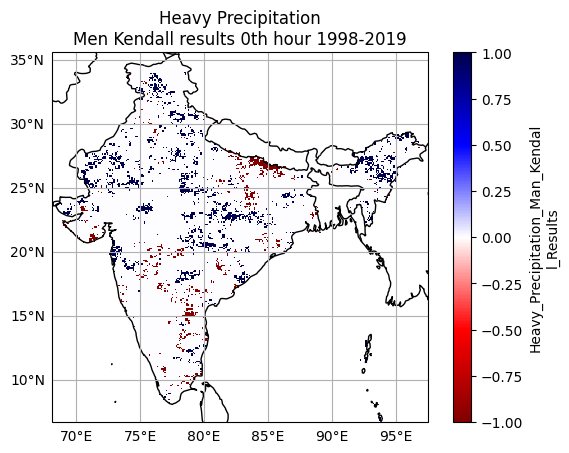

In [17]:
heavy_prec = LoadData("00")
plot_data = ManKendallTest(heavy_prec) # with alpha = 0.2
PlotGraph(plot_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

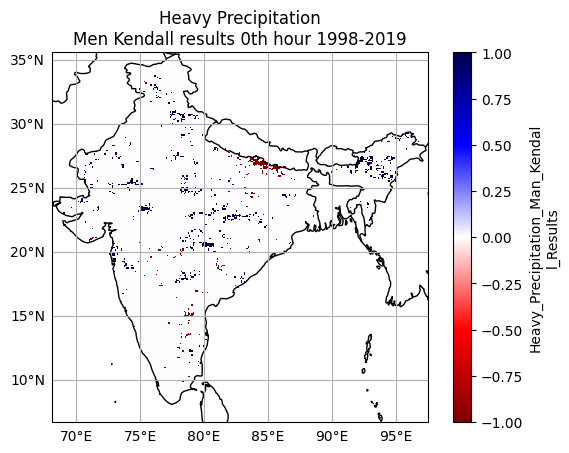

In [15]:
heavy_prec = LoadData("00")
plot_data = ManKendallTest(heavy_prec) # with alpha = 0.1
PlotGraph(plot_data)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

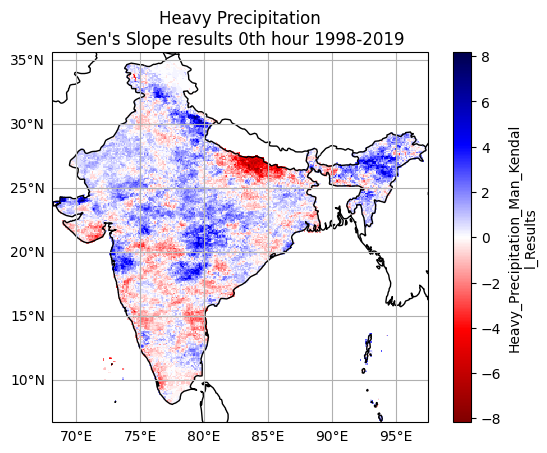

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


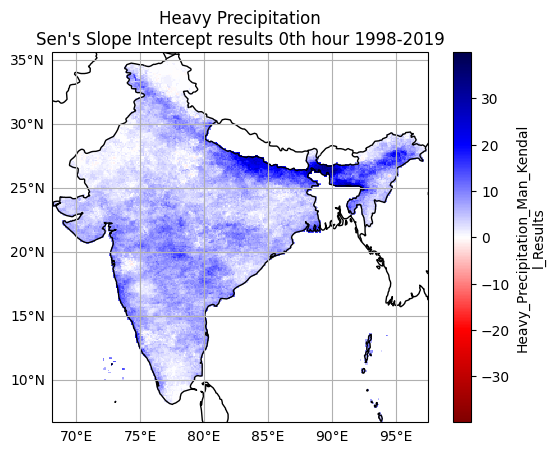

In [18]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept")

## 3rd Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

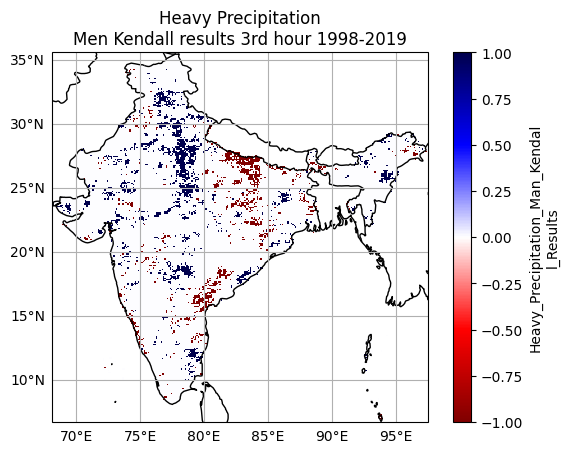

In [19]:
heavy_prec = LoadData("03")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="3rd")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

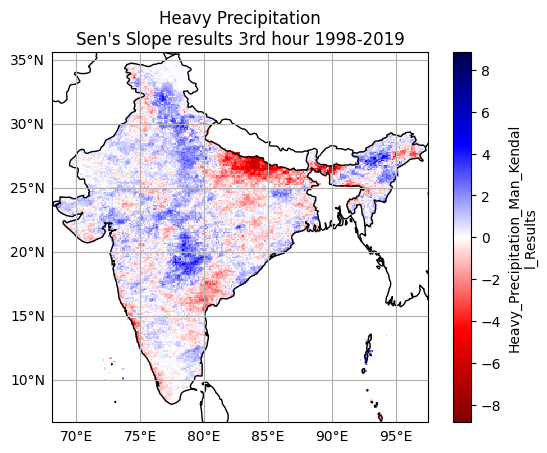

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


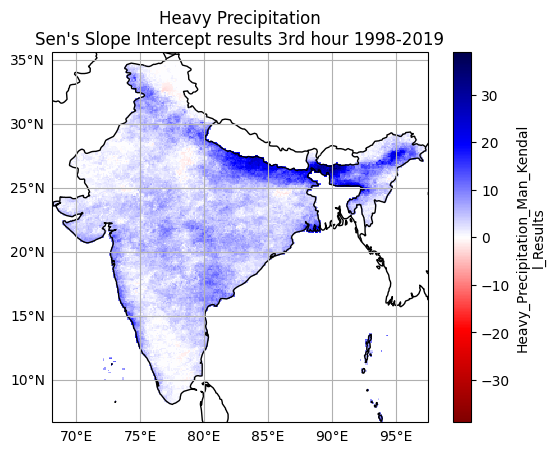

In [20]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="3rd")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="3rd")

## 6th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

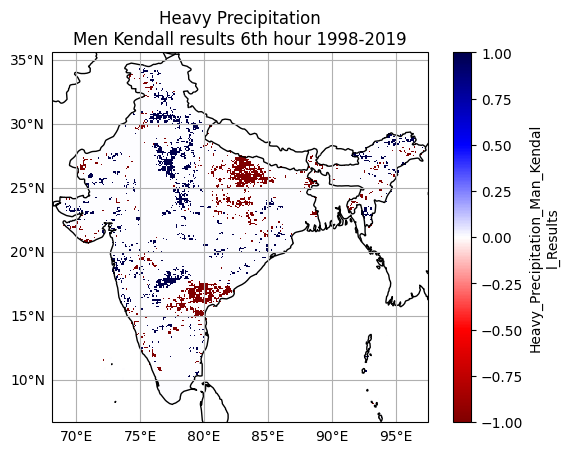

In [21]:
heavy_prec = LoadData("06")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="6th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

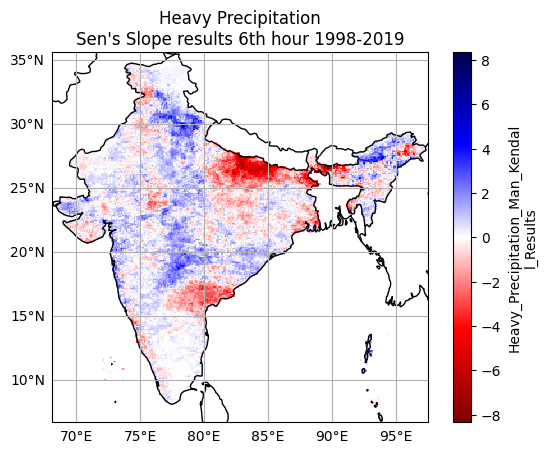

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


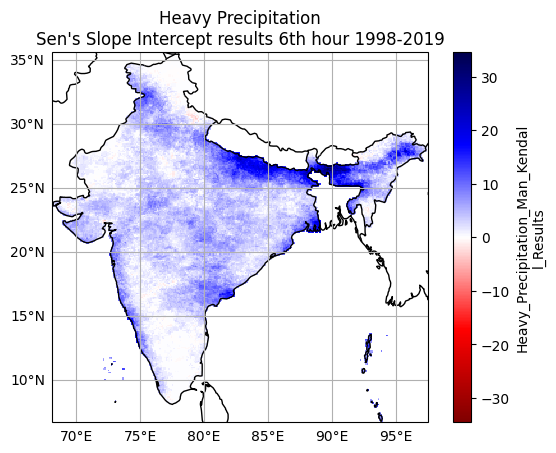

In [22]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="6th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="6th")

## 9th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

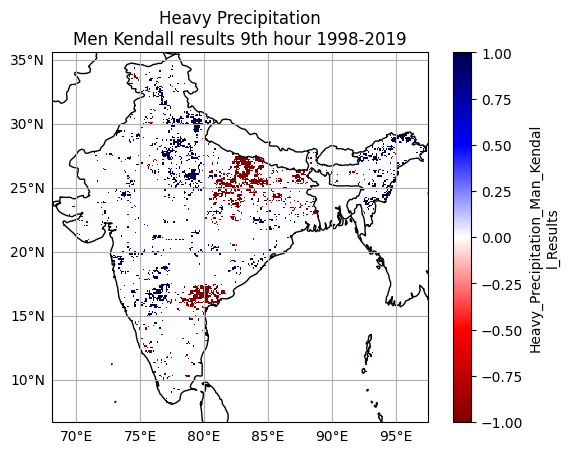

In [23]:
heavy_prec = LoadData("09")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="9th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

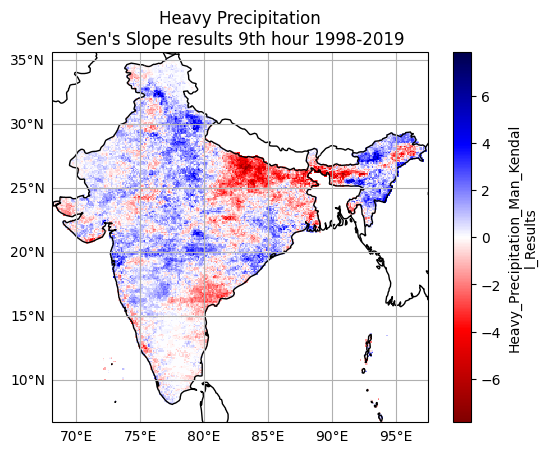

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


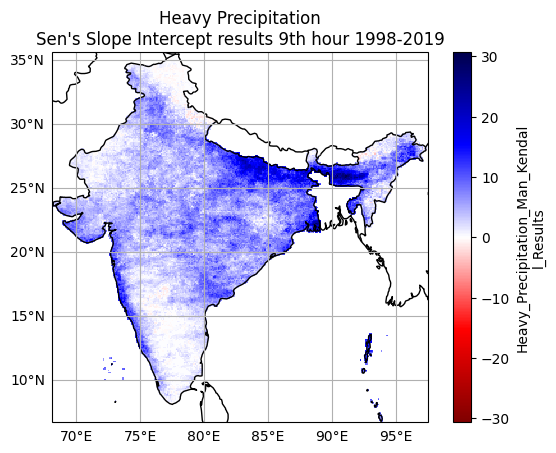

In [24]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="9th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="9th")

## 12th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

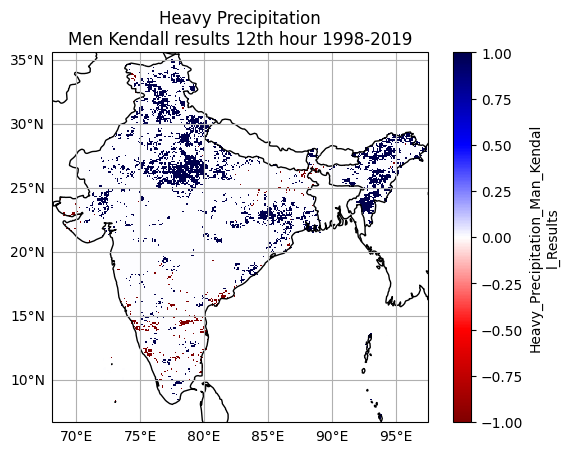

In [25]:
heavy_prec = LoadData("12")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="12th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

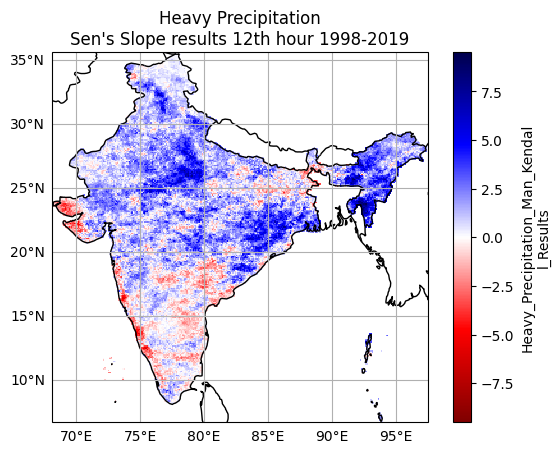

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


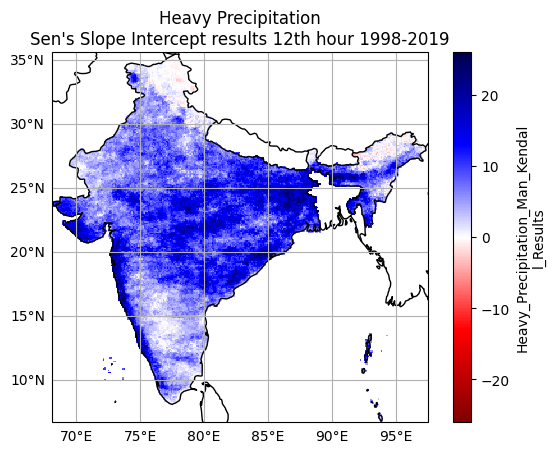

In [26]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="12th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="12th")

## 15th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

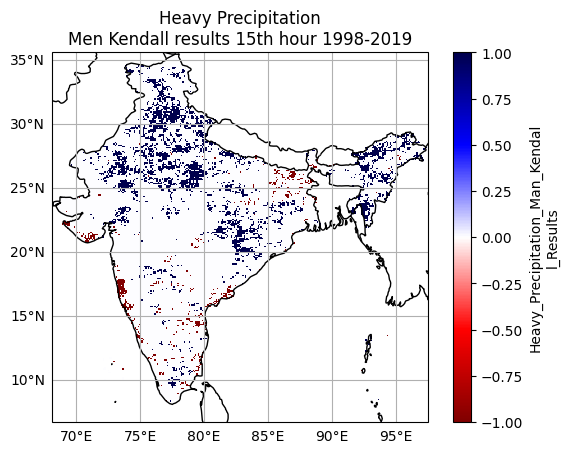

In [27]:
heavy_prec = LoadData("15")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="15th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

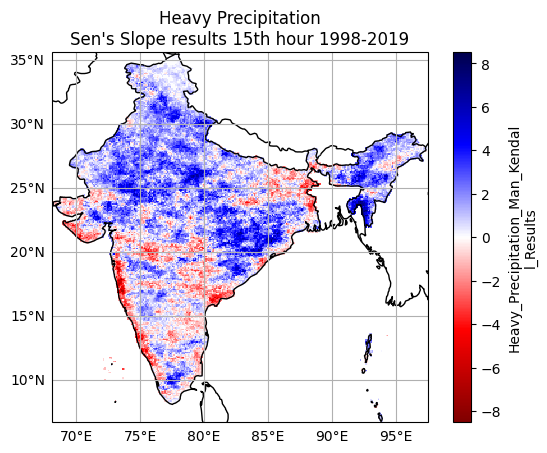

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


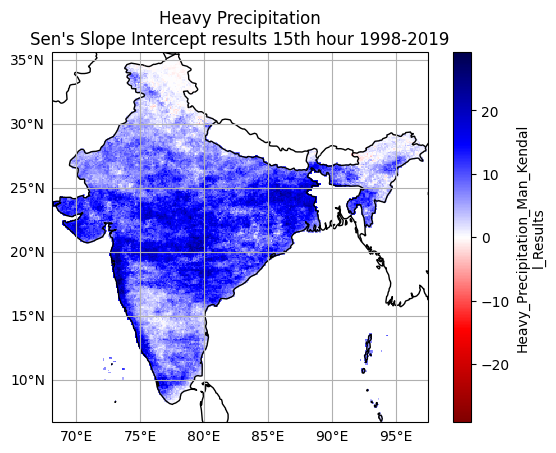

In [28]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="15th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="15th")

## 18th Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

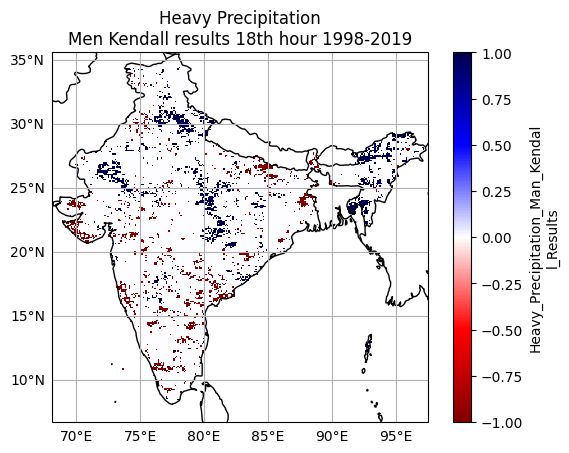

In [29]:
heavy_prec = LoadData("18")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="18th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

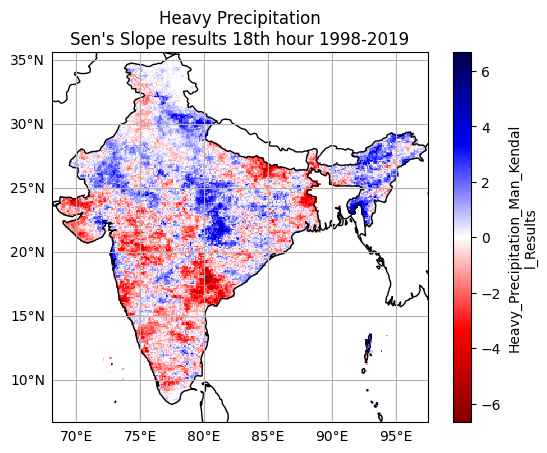

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


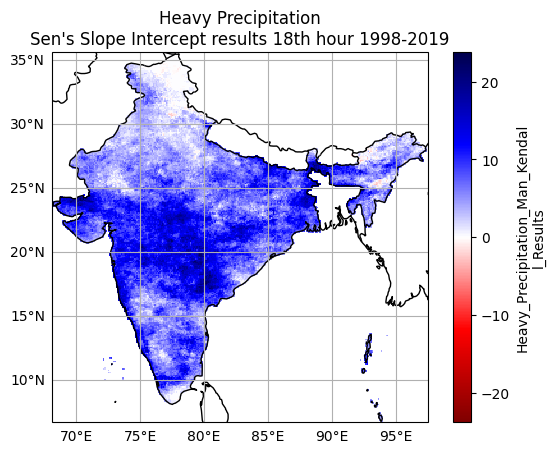

In [30]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="18th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="18th")

## 21st Hour

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

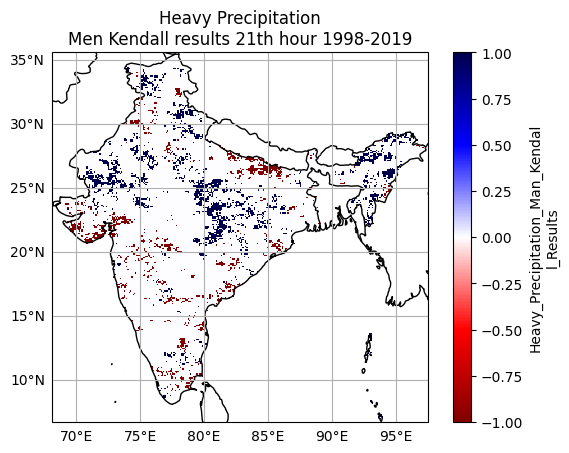

In [31]:
heavy_prec = LoadData("21")
plot_data = ManKendallTest(heavy_prec)
PlotGraph(plot_data,hour="21th")

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

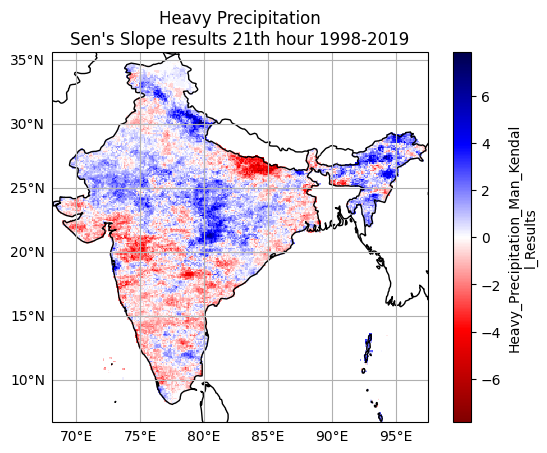

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


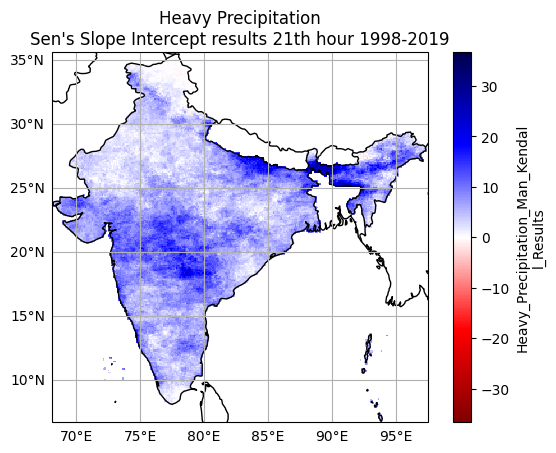

In [32]:
plot_data,intercept_plot = SenSlope(heavy_prec)
PlotGraph(plot_data,test="Sen\'s Slope",hour="21th")
PlotGraph(intercept_plot,test="Sen\'s Slope Intercept",hour="21th")

## Grid Plots for TRMM

In [10]:
hour = ["00","03","06","09","12","15","18","21"]
for h in hour:
    heavy_prec = LoadData(h)
    plot_data,intercept_plot,count = SenSlope(heavy_prec)
    CountGrids(count)

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


p=84,n=-141,nn=9047,o=4651
Total = 13923


/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


p=79,n=-57,nn=9047,o=4740
Total = 13923


/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


p=42,n=-28,nn=9047,o=4806
Total = 13923


/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


p=44,n=-77,nn=9047,o=4755
Total = 13923


/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


p=30,n=-295,nn=9047,o=4551
Total = 13923


/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


p=33,n=-136,nn=9047,o=4707
Total = 13923


/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


p=40,n=-124,nn=9047,o=4712
Total = 13923


/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


p=55,n=-139,nn=9047,o=4682
Total = 13923


In [11]:
increasing_count

[84, 79, 42, 44, 30, 33, 40, 55]

In [12]:
decreasing_count

[-141, -57, -28, -77, -295, -136, -124, -139]

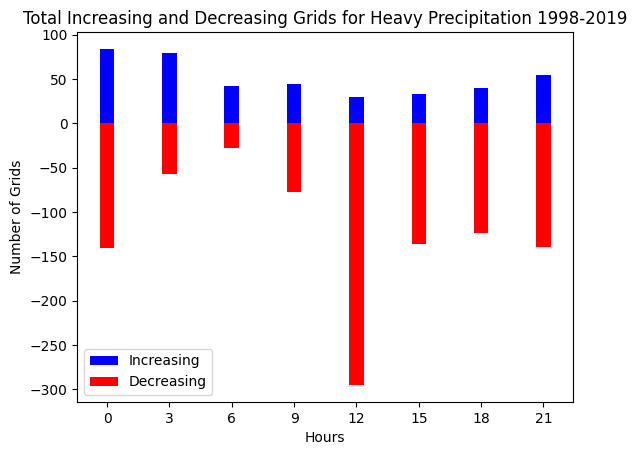

In [13]:
GridPlot(increasing_count,decreasing_count)

In [20]:
d = []
for i in decreasing_count:
    d.append(-i)
d

[141, 57, 28, 77, 295, 136, 124, 139]

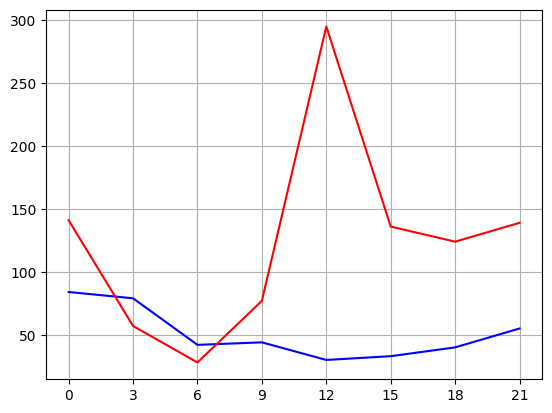

In [21]:
x = [0,3,6,9,12,15,18,21]
plt.plot(x,increasing_count,color='b')
plt.plot(x,d,color='r')
plt.xticks(x)
plt.grid()
plt.show()

## Grid Plot for GPM

In [12]:
hour = ["00","03","06","09","12","15","18","21"]
for h in hour:
    heavy_prec = LoadData(h)
    plot_data,intercept_plot,count = SenSlope(heavy_prec)
    CountGrids(count)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

p=16480,n=-10576,nn=56009,o=1901
Total = 84966


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

p=15316,n=-11043,nn=56009,o=2598
Total = 84966


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

p=14473,n=-11390,nn=56009,o=3094
Total = 84966


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

p=15655,n=-10945,nn=56009,o=2357
Total = 84966


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

p=21314,n=-6741,nn=56009,o=902
Total = 84966


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

p=19706,n=-8305,nn=56009,o=946
Total = 84966


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

p=13150,n=-14014,nn=56009,o=1793
Total = 84966


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

p=15065,n=-12297,nn=56009,o=1595
Total = 84966


In [14]:
increasing_count

[16480, 15316, 14473, 15655, 21314, 19706, 13150, 15065]

In [15]:
decreasing_count

[-10576, -11043, -11390, -10945, -6741, -8305, -14014, -12297]

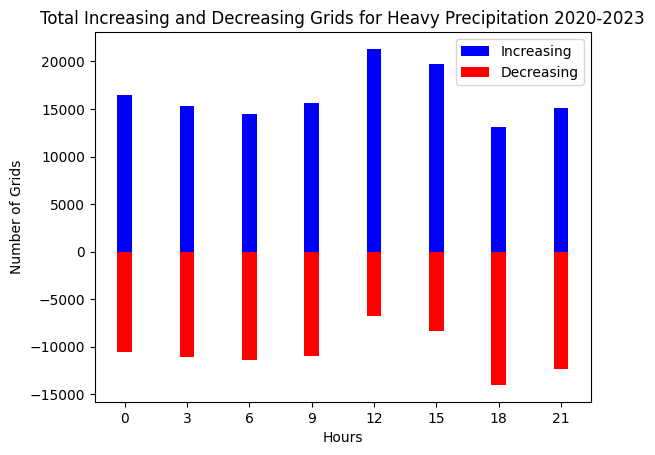

In [16]:
GridPlot(increasing_count,decreasing_count,year='2020-2023')